In [121]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [122]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [123]:
device

'cpu'

In [124]:
df = pd.read_csv("./scaled_average_daily_data.csv",parse_dates=["time"],index_col="time")

In [125]:
df.drop(["Unnamed: 0"],axis = 1, inplace = True)

In [126]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns = df.columns #remove P, save as diff scaler, use fit to fit with train data then use transform to transform train and test labels and once you train the model and get the output apply inverse transform of the output scaler to get the values back as usage
for i in columns:
    df[i] = scaler.fit_transform(np.array(df[i]).reshape(-1,1))

In [127]:
df

,P,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m
time,,,,,,,
2014-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018769
2015-01-01,0.486541,0.271334,0.596531,0.439440,0.661955,0.273136,0.088978
2015-01-02,0.877035,0.766595,0.545799,0.729750,0.663066,0.301585,0.149064
2015-01-03,0.823470,0.670920,0.612784,0.699092,0.664194,0.261825,0.058479
2015-01-04,0.851558,0.740134,0.557484,0.721045,0.665466,0.269366,0.086023
...,...,...,...,...,...,...,...
2016-12-27,0.863234,0.739363,0.525811,0.706662,0.657835,0.309254,0.387322
2016-12-28,0.782403,0.569185,0.657115,0.652914,0.658444,0.288389,0.360733
2016-12-29,0.798444,0.587937,0.652310,0.661998,0.659125,0.214225,0.320850


In [128]:
training_data_len = int(len(df) * .8)
training_data_len

#Splitting the dataset
train_data = df[:training_data_len].iloc[:,:1]
test_data = df[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)

(585, 1) (147, 1)


In [129]:
data = df["P"].values

In [130]:
data = torch.FloatTensor(data).view(-1, 1).to(device)

In [131]:
sequence_length = 30
X_train, y_train = [], []
for i in range(len(train_data) - sequence_length):
    X_train.append(train_data[i:i+sequence_length])
    y_train.append(train_data[i+1:i+sequence_length+1])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_train.shape, y_train.shape

(torch.Size([555, 30, 1]), torch.Size([555, 30, 1]))

In [132]:
sequence_length = 30
X_test, y_test = [], []
for i in range(len(test_data) - sequence_length):
    X_test.append(test_data[i:i+sequence_length])
    y_test.append(test_data[i+1:i+sequence_length+1])
X_test, y_test = np.array(X_test), np.array(y_test)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test.shape, y_test.shape

(torch.Size([117, 30, 1]), torch.Size([117, 30, 1]))

In [133]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def calculate_metrics(model, dataloader,model_name,batch_size,learning_rate):
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in dataloader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            all_predictions.append(predictions_test.cpu().numpy())
            all_targets.append(batch_y_test.cpu().numpy())

    # Calculate RMSE, MSE
    all_predictions = np.concatenate(all_predictions, axis=0).squeeze()
    all_targets = np.concatenate(all_targets, axis=0).squeeze()
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    mse = mean_squared_error(all_targets, all_predictions)
    mae = mean_absolute_error(all_targets,all_predictions)
    # Calculate SMAPE
    numerator = np.abs(all_predictions - all_targets)
    denominator = (np.abs(all_targets) + np.abs(all_predictions)) / 2
    smape = np.mean(np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator != 0)) * 100
    mape = np.mean(np.abs((all_targets - all_predictions) / all_targets)) * 100
    # Calculate MFE
    mfe = np.mean(all_targets - all_predictions)

    # Calculate R-squared
    r2 = r2_score(all_targets, all_predictions)
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")

    print(f"SMAPE: {smape}%")
    print(f"R2: {r2}")
    print(f"MFE: {mfe}")
    print(f"MAPE:{mape}%")

    metrics_dict = {
        'ModelName': model_name,
        "Batch Size":batch_size,
        "Learning Rate":learning_rate,
        'RMSE': rmse,
        'MAE': mae,
        'SMAPE': smape,
        'MFE': mfe,
        'R2': r2,
        'MAPE': mape
    }

    return metrics_dict

In [134]:
import torch
import torch.nn as nn
from tqdm import tqdm

def train_model(model, train_loader, test_loader, loss_fn, optimizer, num_epochs=50, device="cpu"):

    train_hist = []
    test_hist = []
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        total_loss = 0.0

        # Training
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            predictions = model(batch_X)
            loss = loss_fn(predictions, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()


        # Calculate average training loss
        average_loss = total_loss / len(train_loader)
        train_hist.append(average_loss)

        # Validation on test data
        model.eval()
        with torch.no_grad():
            total_test_loss = 0.0
            for batch_X_test, batch_y_test in test_loader:
                batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
                predictions_test = model(batch_X_test)
                test_loss = loss_fn(predictions_test, batch_y_test)

                total_test_loss += test_loss.item()

        # Calculate average test loss
        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')
    return test_hist, train_hist


In [135]:
def data_setup(X_train,y_train,X_test,y_test,batch_size=16):
  # Create DataLoader for batch training
  train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  # Create DataLoader for batch training
  test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  return train_loader,test_loader


In [136]:
def forecast(num_forecast_steps,model,X_test,test_data):

  # Convert to NumPy and remove singleton dimensions
  sequence_to_plot = X_test.squeeze().cpu().numpy()

  # Use the last 30 data points as the starting point
  historical_data = sequence_to_plot[-1]
  # Initialize a list to store the forecasted values
  forecasted_values = []

  # Use the trained model to forecast future values
  with torch.no_grad():
      for _ in range(num_forecast_steps*2):
          # Prepare the historical_data tensor
          historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
          # Use the model to predict the next value
          predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]

          # Append the predicted value to the forecasted_values list
          forecasted_values.append(predicted_value[0])

          # Update the historical_data sequence by removing the oldest value and adding the predicted value
          historical_data = np.roll(historical_data, shift=-1)
          historical_data[-1] = predicted_value


  # Generate futute dates
  last_date = test_data.index[-1]

  # Generate the next 30 dates
  future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=num_forecast_steps)
  combined_index = test_data.index.append(future_dates)
  return sequence_to_plot,combined_index,forecasted_values
  #set the size of the plot



In [137]:
import os
import seaborn as sns
def plot_loss_curves(train_hist,test_hist,num_epochs,name,test_data,X_test,model,batch=16):
  x = np.linspace(1,num_epochs,num_epochs)
  plt.plot(x,train_hist,scalex=True, label="Training loss")
  plt.plot(x, test_hist, label="Test loss")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  # folder_path = f"/content/batch_{batch}"
  # os.makedirs(folder_path, exist_ok=True)

    # Save the loss curve plot
  # plt.savefig(os.path.join(folder_path, f"{name}_loss_curve.png"))
  plt.show()
  sequence_to_plot,combined_index,forecasted_values = forecast(30,model,X_test,test_data)
  plt.rcParams['figure.figsize'] = [14, 4]
  data = pd.DataFrame({
        'Data Type': ['Observed'] * len(test_data['P'][-30:]) + ['Forecasted'] * len(forecasted_values),
        'P-Value': np.concatenate([test_data['P'][-30:], forecasted_values])
    })
  plt.figure()
  sns.violinplot(x='Data Type', y='P-Value', data=data, palette='muted')
  plt.title('Observed and Forecasted P-Value Distribution')
  plt.xlabel('Data Type')
  plt.ylabel('P-Value')

  # Save the violin plot
  # plt.savefig(os.path.join(folder_path, f"{name}_violin_plot.png"))
  plt.show()
    #Test data
  plt.plot(test_data.index[-100:-30], test_data['P'][-100:-30], label = "test_data", color = "b")
  #reverse the scaling transformation
  original_cases = np.expand_dims(sequence_to_plot[-1], axis=0).flatten()

  #the historical data used as input for forecasting
  plt.plot(test_data.index[-30:], original_cases, label='Actual P-Value', color='green')

  #Forecasted Values
  #reverse the scaling transformation
  forecasted_cases = np.expand_dims(forecasted_values, axis=0).flatten()
  # plotting the forecasted values
  plt.plot(combined_index[-60:], forecasted_cases, label='Forecasted P-Value', color='red')
  plt.xlabel('Time Step')
  plt.ylabel('P-Value')
  plt.legend()
  # plt.savefig(os.path.join(folder_path, f"{name}_forecast_plot.png"))
  residuals = original_cases - np.array(test_data['P'][-30:])

  plt.figure()
  plt.scatter(test_data.index[-30:], residuals, color='orange', label='Residuals')
  plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
  # plt.savefig(os.path.join(folder_path, f"{name}_residual_plot.png"))
  plt.grid(True)
  plt.show()


In [138]:
import torch.nn.init as init
class LSTMWithAttentionModel(nn.Module):
  def __init__(self,in_layers,hidden_layers,num_layers,out_layers):
    super(LSTMWithAttentionModel,self).__init__()
    self.lstm = nn.LSTM(in_layers,hidden_layers*2,num_layers,batch_first=True)
    self.attention = nn.Sequential(
            nn.Linear(hidden_layers * 2, hidden_layers),
            nn.Tanh(),
            nn.Linear(hidden_layers, 1)
        )
    self.fc = nn.Linear(hidden_layers*2,out_layers)
    self.activation = nn.ReLU()
    self.apply(self.weights_init)
  def forward(self, x):
        lstm_output, _ = self.lstm(x)
        attention_weights = torch.softmax(self.attention(lstm_output), dim=1)
        attended_lstm = attention_weights * lstm_output
        output = self.fc(self.activation(attended_lstm))
        return output
  def weights_init(self,model):
    for layer in model.children():
        if isinstance(layer, nn.LSTM):
            for name, param in layer.named_parameters():
                if 'weight' in name:
                    init.xavier_uniform_(param)
                elif 'bias' in name:
                    init.constant_(param, 0)
        elif isinstance(layer, nn.Linear):
            init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                init.constant_(layer.bias, 0)



In [139]:
train_loader,test_loader = data_setup(X_train,y_train,X_test,y_test,32)

In [148]:
num_epochs = 50
input_size = 1
num_layers = 3
hidden_size = 64
output_size = 1

# Define the model, loss function, and optimizer
model_1 = LSTMWithAttentionModel(input_size, hidden_size, num_layers,1).to(device)
loss_fn_1 = torch.nn.SmoothL1Loss()


optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=0.01)

test_hist_1,train_hist_1= train_model(model_1,train_loader,test_loader,loss_fn_1,optimizer_1,50,device=device)

 20%|██        | 10/50 [00:04<00:16,  2.44it/s]

Epoch [10/50] - Training Loss: 0.0177, Test Loss: 0.0223


 40%|████      | 20/50 [00:08<00:12,  2.45it/s]

Epoch [20/50] - Training Loss: 0.0166, Test Loss: 0.0228


 60%|██████    | 30/50 [00:12<00:09,  2.20it/s]

Epoch [30/50] - Training Loss: 0.0151, Test Loss: 0.0200


 80%|████████  | 40/50 [00:17<00:04,  2.27it/s]

Epoch [40/50] - Training Loss: 0.0108, Test Loss: 0.0153


100%|██████████| 50/50 [00:21<00:00,  2.33it/s]

Epoch [50/50] - Training Loss: 0.0052, Test Loss: 0.0151


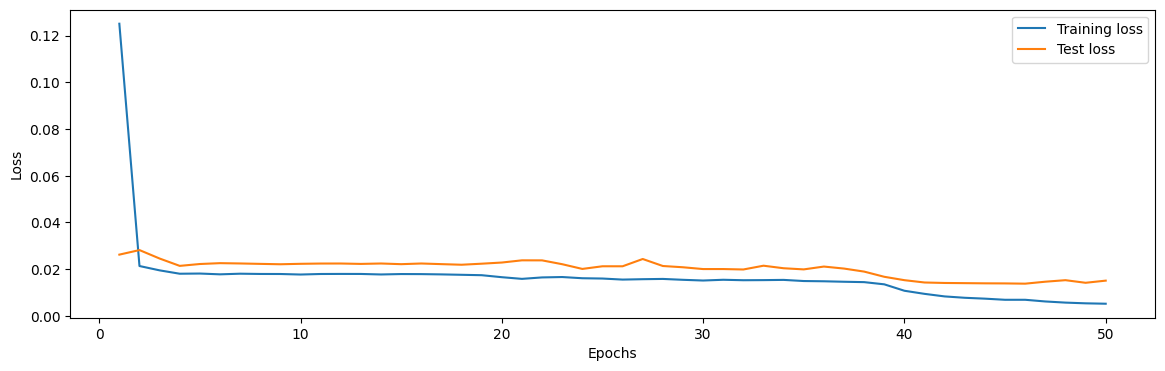

/var/folders/r9/ld6l7sg96rn5bb8nz9j2dx580000gn/T/ipykernel_74419/1360615475.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value
/var/folders/r9/ld6l7sg96rn5bb8nz9j2dx580000gn/T/ipykernel_74419/4027556544.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Data Type', y='P-Value', data=data, palette='muted')


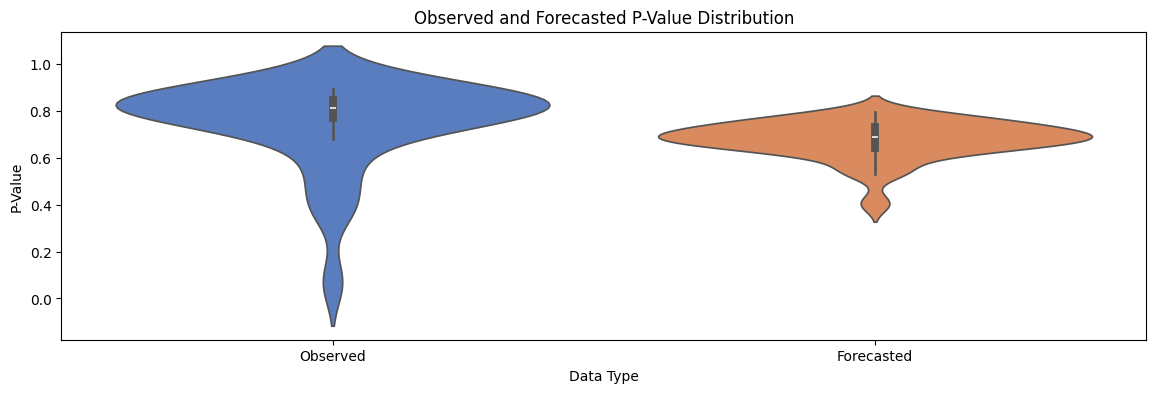

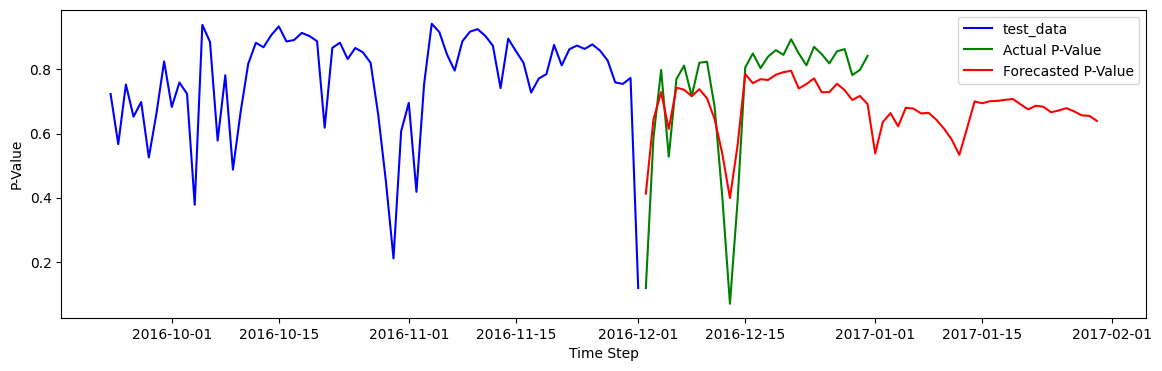

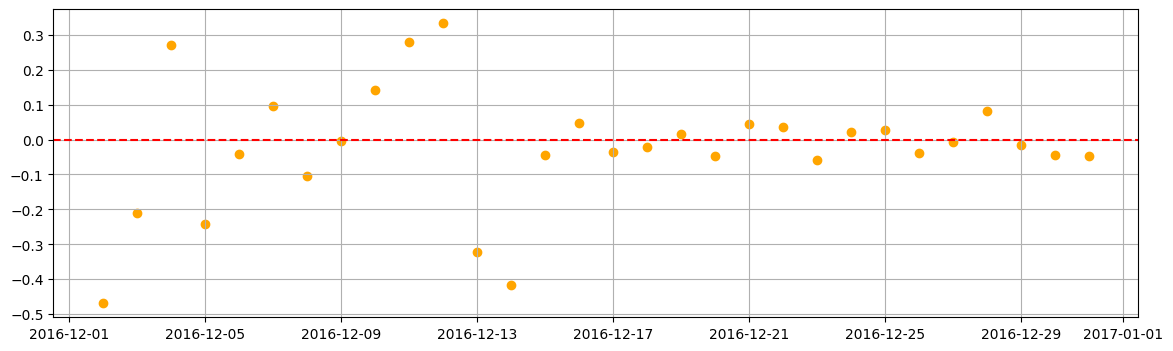

In [149]:
plot_loss_curves(train_hist_1,test_hist_1,50,"lstm_with_attention_0.01_16",test_data,X_test,model_1)